# **Harris Corner Detector**

Implement a baisc Harris Corner Detector from scratch

refs:
- https://www.cs.umd.edu/class/fall1019/cmsc426-0101/files/12_HarrisCornerDetection.pdf
- https://www.cs.cmu.edu/~16385/s17/Slides/6.2_Harris_Corner_Detector.pdf
- https://www.cse.psu.edu/~rtc12/CSE486/lecture06.pdf
- http://www.bmva.org/bmvc/1988/avc-88-023.pdf
- https://docs.opencv.org/3.4/dc/d0d/tutorial_py_features_harris.html

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

%matplotlib inline

# Settings

In [2]:
block_sz = 5
k = 0.05
thresh = 1e-2

In [3]:
# Sobel kernels
Sx = np.array([
    [1, 0, -1],
    [2, 0, -2],
    [1, 0, -1]])

Sy = Sx.T

# Gaussian Kernel
G = np.array([
    [1, 2, 1],
    [2, 4, 2],
    [1, 2, 1]])/16

## Get Test Image

In [4]:
from skimage.data import brick

image = brick().astype(np.float32)

# (OPTIONAL) blurr image --> This will change hyperparameters
# image = cv2.blur(image, ksize=(5,5))

# 0-1 normalize
image /= image.max()

c:\Users\itber\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Compute x and y derivatives

In [5]:
dx = cv2.filter2D(image, ddepth=-1, kernel=Sx)
dy = cv2.filter2D(image, ddepth=-1, kernel=Sy)

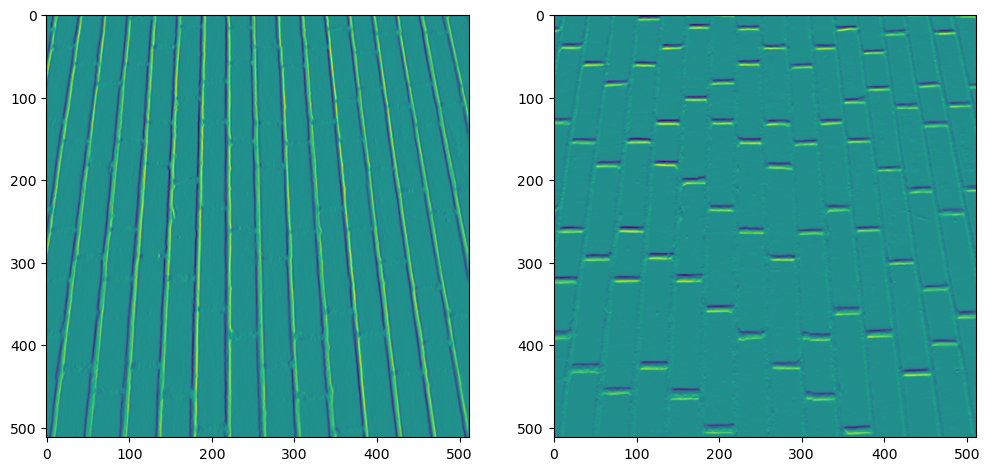

In [6]:
_, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(dx)
ax[1].imshow(dy);

In [7]:
# get smoothed square derivatives

# # no Filter
# A = dx*dx
# B = dy*dy
# C = dx*dy

# Gaussian Filter
A = cv2.filter2D(dx*dx, ddepth=-1, kernel=G)
B = cv2.filter2D(dy*dy, ddepth=-1, kernel=G)
C = cv2.filter2D(dx*dy, ddepth=-1, kernel=G)

# Box Filter
# A = cv2.boxFilter(dx*dx, ddepth=-1, ksize=(block_sz,block_sz))
# B = cv2.boxFilter(dy*dy, ddepth=-1, ksize=(block_sz,block_sz))
# C = cv2.boxFilter(dx*dy, ddepth=-1, ksize=(block_sz,block_sz))

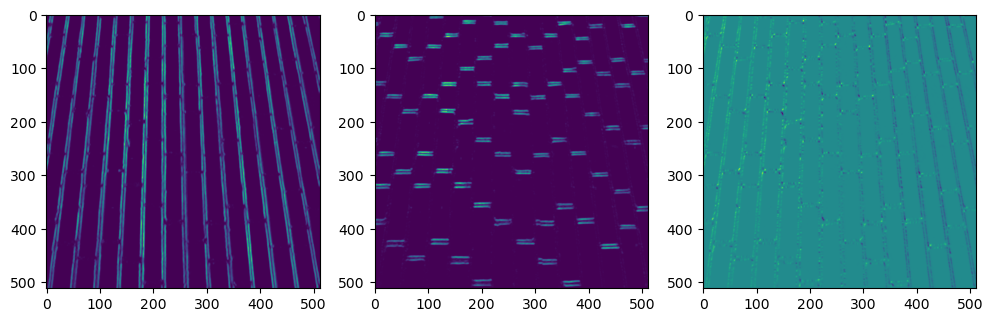

In [8]:
_, ax = plt.subplots(1, 3, figsize=(12, 8))
ax[0].imshow(A)
ax[1].imshow(B)
ax[2].imshow(C);

## Compute Corner Response at each pixel

In [9]:
R = (A*B - (C*C)) - k*(A + B)*(A + B)

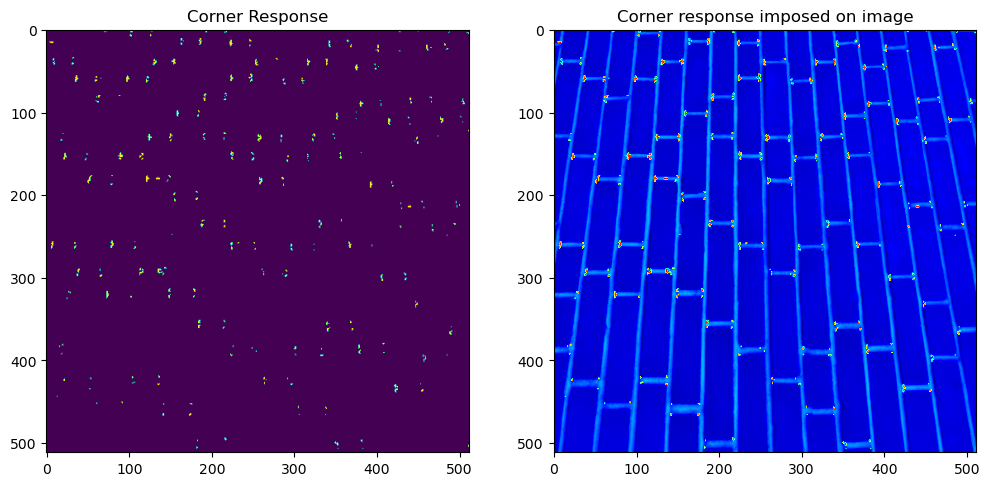

In [125]:
_, ax = plt.subplots(1, 2, figsize=(12, 8))
ax[0].imshow(R > 1e-2)
ax[0].set_title("Corner Response")
ax[1].imshow(image*2 + (R > 1e-2)*3, cmap='jet')
ax[1].set_title("Corner response imposed on image");

## Get individual corners

In [12]:
# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(np.uint8(R > 1e-2))
# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(image, np.float32(centroids), (9,9), (-1,-1), criteria)

In [13]:
image_out = np.dstack((image, image, image))
for (x, y) in corners:
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    cv2.circle(image_out, (x, y), radius=3, color=(0, 255, 0), thickness=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


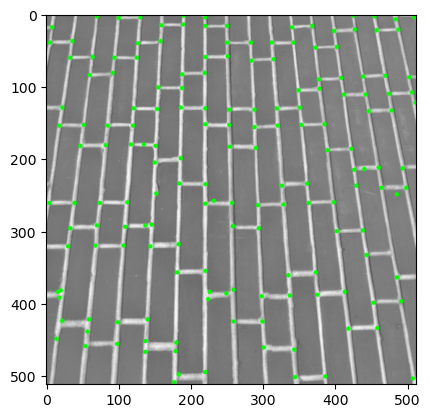

In [14]:
plt.imshow(image_out);

Compare results with opencv

In [15]:
dst = cv2.cornerHarris(image,2,3,0.05)
dst = cv2.dilate(dst,None)
ret, dst = cv2.threshold(dst,0.05*dst.max(),255,0)
dst = np.uint8(dst)

# find centroids
ret, labels, stats, centroids = cv2.connectedComponentsWithStats(dst)
# define the criteria to stop and refine the corners
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)
corners = cv2.cornerSubPix(image,np.float32(centroids),(5,5),(-1,-1),criteria)

image_out2 = np.dstack((image, image, image))
for (x, y) in corners:
    x = np.round(x).astype(int)
    y = np.round(y).astype(int)
    cv2.circle(image_out2, (x, y), radius=3, color=(0, 255, 0), thickness=-1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


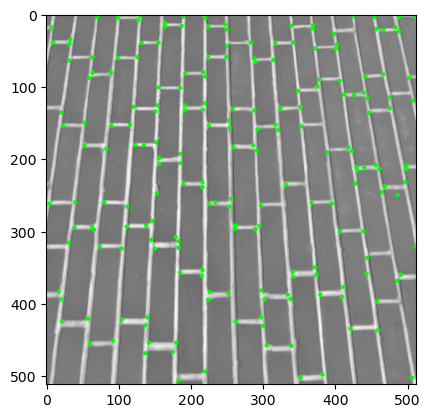

In [16]:
plt.imshow(image_out2)

# Explore derivative distributions around each corner 

In [136]:
x, y = corners[200]

x = np.round(x).astype(int)
y = np.round(y).astype(int)


# manually get location
x, y = 493, 213

x, y

(493, 213)

Construct M matrix for a single pixel

In [137]:
dx[x, y], dy[x, y]

(-0.014492691, -0.004830897)

In [138]:
M = np.array([[A[x, y], C[x, y]],
              [C[x, y], B[x, y]]])
M

array([[0.00045363, 0.00038361],
       [0.00038361, 0.00087954]], dtype=float32)

Compute eigenvalues

In [144]:
(alpha, beta), _ = np.linalg.eig(M)
alpha, beta

(0.0002278237, 0.0011053451)

In [140]:
# x, y = 493, 213 # corner
# x, y = 200, 200 # edge
# x, y = 485, 485 # flat region with win size=12
# x, y = 85, 485 # diagonal edge
w_sz = 20 # window size
dx_win = dx[x-w_sz:x+w_sz+1, y-w_sz:y+w_sz+1]
dy_win = dy[x-w_sz:x+w_sz+1, y-w_sz:y+w_sz+1]


# center data
dx_win -= dx_win.mean()
dy_win -= dy_win.mean()

In [141]:
dx_win.min(), dx_win.max(), dy_win.min(), dy_win.max()

(-1.5915773, 1.2441714, -1.0736058, 0.9360561)

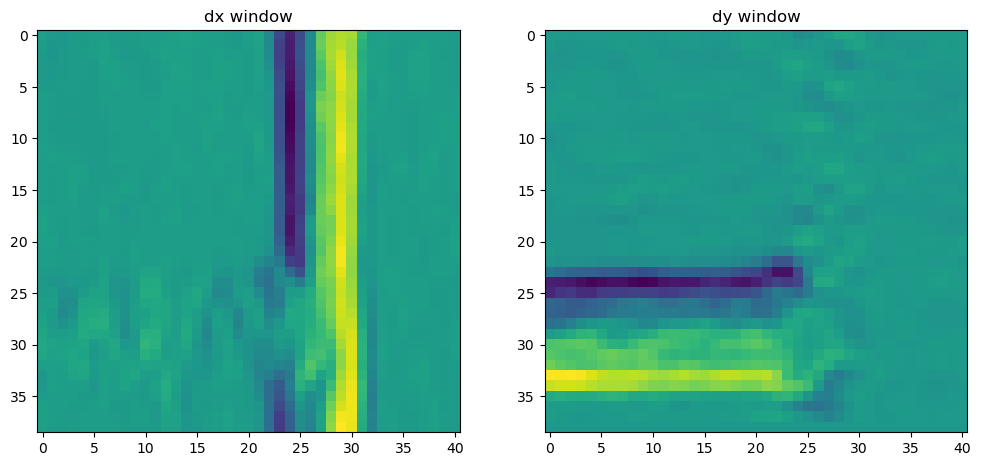

In [142]:
_, ax = plt.subplots(1, 2, figsize=(12, 8))

ax[0].imshow(dx_win)
ax[0].set_title("dx window")

ax[1].imshow(dy_win)
ax[1].set_title("dy window");

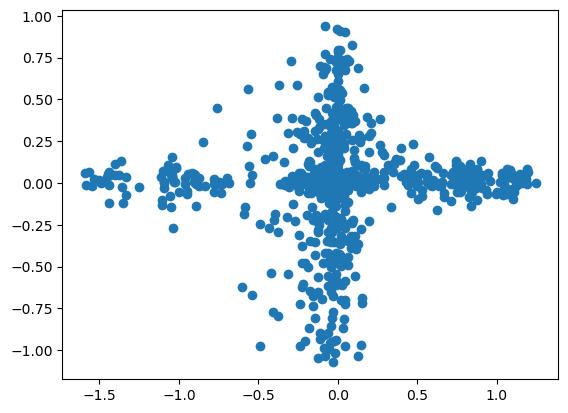

In [143]:
plt.scatter(dx_win.flatten(), dy_win.flatten());